In [ ]:
import scipy.io
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
full_path = F"/content/gdrive/My Drive/Colab Notebooks/PAM_sig.csv"
mat = scipy.io.loadmat(full_path)
Data_from_matlab=(mat['PAM_shaped'])

Mounted at /content/gdrive/


# Functions and libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def binary_batch_to_decimal(Targets):
    """
    This Function Takes a Matrix of the size N * S
    - N number of symbols
    - S Symbol size (#Bits of each symbol )
    and returns a tensor of integers 
    Example: 
    Targets: [[0, 1, 1, 0, 0, 1],
              [1, 0, 1, 1, 0, 1],
              [1, 1, 1, 0, 1, 1]]
    int_Targets: [3, 5, 2, 1, 7]
    """
    int_Targets = np.zeros([len(Targets[:,0])])    
    for j in range(len(Targets[:,0])):
        x=0
        l=len(Targets[0,:])
        for i in range(l):
                x+=Targets[j,i]*2**(l-1-i) 
        int_Targets[j]=x
    return int_Targets.reshape(-1,1)

def tx_PAM_Gen(syst): 
  '''
  This fuction generates PAM symbols 
  input: 
    sys: attribute dictionary of system parameters 
  output:
    ref_Bit: the random bits generated
    ref_PAM: the PAM optical coordiantes (any of [0,1,2,3])
  '''
  PRBS_order = syst.PRBS_order # this variable is gotten from Mai's code. we use random data rather than PRBS
  ModuFormat = syst.PMA_order

  ## bit generation

  rbs = np.random.randint(0,2,(2**PRBS_order,1))

  k_bits = np.log2(ModuFormat)
  Nsymbs = np.floor(np.max(np.size((rbs)))/k_bits)

  ref_BIT = rbs[0:int(Nsymbs*k_bits)]
  
  ## PAM level generation
  bit_matrix = ref_BIT.reshape(int(Nsymbs),int(k_bits))
  tx_vec = binary_batch_to_decimal(bit_matrix)
  

  ref_PAM = tx_vec # pammod(tx_vec,ModuFormat);

  return ref_BIT,ref_PAM

def rectpulse(ref_PAM, sys):
	"""
		Parameters
		------------
		ref_PAM: a sequence of PAM symbols for examplpe for PAM 4 [0,1,2,3] 
    syst: atribute dictionary of the system 
      syst.puls_sps is used here which determines the sample per symbol ratio
		samplesPerSymbol

		Returns
		------------
		outNRZ: NRZ train pulses. 
	"""
	outNRZ = [ref_PAM[i] for i in range(0,len(ref_PAM)) for j in range(0,syst.puls_sps)]
	outNRZ = np.array(outNRZ) 	
	return outNRZ



#Main

const total power:  1.0
Tx signal total power:  1.0000000000000002
******Laser*********
Laser Linewidth =  1.0  MHz


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


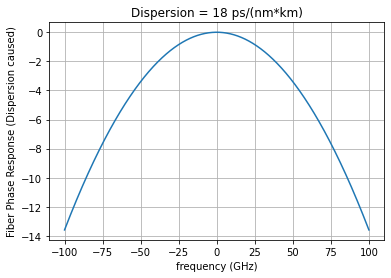

******Fiber*********
Wavelength = 1550 nm
Fiber Length = 3 Km
Dispersion = 18 ps/(nm*km)
Attenuation = 0 dB/km
***** Totoal Power *****
       0.9999999999999986
0
1
(262144, 1)
(262144, 1)
2
3
4
SER is:  0.2931365966796875


In [ ]:
# np.random.seed(123)
if __name__ == "__main__":    
  DAC = AttrDict()    # DAC parameters
  syst = AttrDict()    # System parameters
   
  
  syst.baud_rate = 10e9;
  syst.PMA_order = 4;
  syst.PRBS_order = 19;

  syst.roll_off = 1;
  syst.puls_span = 128;
  syst.puls_sps = 20;

  DAC.sampling_rate = syst.baud_rate*syst.puls_sps

  
  syst.ASE_SNR = 10
  
  Totla_S_error  = 0
  symbols = 0

  PAM_const = (np.sqrt(np.array([0,1,2,3]))).reshape(-1,1)
  PAM_const_norm = PAM_const/np.sqrt(np.mean(PAM_const**2))
  print('const total power: ', np.sqrt(np.mean(PAM_const_norm**2)))

  ## PAM level generation (1-sps)
  ref_BIT,ref_PAM = tx_PAM_Gen(syst)
  symbols+=np.max(ref_PAM.shape)

  PAM_shaped = rectpulse(ref_PAM, syst) # Data_from_matlab 
  PAM_shaped=np.sqrt(PAM_shaped)
  # Normalize power to one
  pow_total=np.mean(PAM_shaped**2)
  PAM_shaped = PAM_shaped/np.sqrt(pow_total) 
  print('Tx signal total power: ', np.sqrt(np.mean(PAM_shaped**2)))
  ###############################################################
  ## laser phase noise
  laser_power=10**(0/10) # 0 dBm
  tx_linewidth=1e6 #laser line width
  Data_in_Func=PAM_shaped
  d_t=1/(syst.baud_rate)
  NoiseSamp = np.random.randn(np.max(np.size(Data_in_Func)), 2)
  PNt = (2*np.pi*tx_linewidth*d_t)*np.cumsum(NoiseSamp[:,0]).reshape(-1,1) # considers only firtst dimention of the NoiseSamp
  Data_out_Laser = np.sqrt(laser_power)*Data_in_Func*np.exp(1j*PNt) # transmitter phase noise
  Data_out=Data_out_Laser #*sqrt(signal_power); # shape is like [N,1]
  pow_total=np.mean(np.abs(Data_out)**2);
  print('******Laser*********');  
  print('Laser Linewidth = ',(tx_linewidth/1e6),' MHz')
  
  ##############################################################
  # fiber parameters
  Data_in_Func = Data_out #/sqrt(mean(abs(Data_out.^2)));
  BW  = DAC.sampling_rate
  fiber_Length = 3   # [KM]
  Dispersion = 18    # [ps/(nm*km)]   (zero at 1310nm  and <=18 at 1550nm)
  S = 0              # [ps/(nm^2.km)] Dispersion slope
  Attenuation = 0    # 0.2; % [dB/km]        (0.34 at 1310nm  and 0.2  at 1550nm)
  lambdaa = 1550     # [nm] wavelength
  beta2=-1*(Dispersion*1e-12*1e9*lambdaa**2*1e-18)/(2*np.pi*3e8)
  beta3=-1*(S*1e-12*1e18*lambdaa**4*1e-36)/(2*np.pi*3e8)**2
  
  #############################################################
  # dispersion  
  w_T = 2*np.pi*np.array(list(np.arange(0,np.max(np.size(Data_in_Func)/2)))+list(np.arange(-np.max(np.size(Data_in_Func))//2,0))).reshape(-1,1)/(np.max(np.size(Data_in_Func))/BW)
  w = w_T # +min(w_T);  
  HDispersion=np.exp(1j*(beta2*w**2*fiber_Length)/2+1j*(beta3*w**3*fiber_Length)/6)  
  # HDispersion=exp(1i*(beta2*w.^2*fiber_Length)/2);
  # HDispersion2=exp(-1i*(beta2*w.^2*fiber_Length)/2);
  # HDispersion=HDispersion1.*HDispersion2;
  f_fiber = np.fft.fftshift(w_T/(2e9*np.pi))
  plt.plot(f_fiber, np.fft.fftshift((beta2*w**2*fiber_Length)/2+1j*(beta3*w**3*fiber_Length)/6));
  
  plt.xlabel('frequency (GHz)')
  plt.ylabel('Fiber Phase Response (Dispersion caused)')
  plt.title('Dispersion = {} ps/(nm*km)'.format(Dispersion))
  plt.grid(True)
  plt.show()

  Data_out_Fiber = np.fft.ifft(np.fft.fft(Data_in_Func.reshape(1,-1))*HDispersion.reshape(1,-1))
  alpha=10**(0.05*Attenuation*fiber_Length);
  # %         Data_out_Fiber=Data_out_Fiber/sqrt(mean(abs(Data_out_Fiber.^2)));
  Data_out_Fiber=Data_out_Fiber.reshape(-1,1)/alpha;
  
  print('******Fiber*********');
  print('Wavelength = {} nm'.format(lambdaa))
  print('Fiber Length = {} Km'.format(fiber_Length))
  print('Dispersion = {} ps/(nm*km)'.format(Dispersion))
  print('Attenuation = {} dB/km'.format(Attenuation))
  
 
  
  # clear Data_out Data_in_Func
  Data_out=Data_out_Fiber; 

  pow_total=np.mean(np.abs(Data_out)**2);
  print('***** Totoal Power *****\n      ', pow_total)
  


  ##############################################################################
  ## AWGN
  noise = ((1/np.sqrt(2)) * (np.random.randn(np.max(Data_out.shape)) + 1j * np.random.randn(np.max(Data_out.shape)))).reshape(-1,1)
  awgn = (np.sqrt(np.mean(np.abs(Data_out)**2)*(10**(-syst.ASE_SNR/10))) * noise)

  Data_out_ASE = Data_out + awgn
  
  # plt.figure(figsize=(5,5), dpi=150)
  # plt.scatter(Data_out_ASE.real, Data_out_ASE.imag, s = .01)
  # plt.show()
  # sys.exit()


  #PAM resampling and demodulation
  Data_out = np.abs(Data_out_ASE)**2 # photo diode --->check it if mod square
  
  PAM_rx=Data_out[int(syst.puls_sps/2):-1:syst.puls_sps].reshape(1,-1)#sampling at half symbol duration
  # PAM_rx = np.sqrt(PAM_rx)
  print('0')
  RX = []
  for i in range(np.max(PAM_rx.shape)):
    idx = np.argmin(np.abs(PAM_rx[0,i]-PAM_const_norm**2))       
    RX.append(idx)  
  print('1')
  RX = np.array(RX).reshape(-1,1)
  print(RX.shape)
  print(ref_PAM.shape)
  print('2')
  s_errors = np.sum(ref_PAM!= RX)
  print('3')
  Totla_S_error += s_errors
  print('4')

  print('SER is: ', Totla_S_error/symbols)


# TST

In [ ]:
print(np.var(noise.imag))
noise.shape

0.9998554816448536


(5242880, 1)

In [ ]:
a = (1/np.sqrt(2) * (np.random.randn(np.max(Data_out.shape)))+ 1j * np.random.randn(np.max(Data_out.shape))).reshape(-1,1)
print(a.shape)
np.var(a.imag)

(5242880, 1)


0.9984532693189168

In [ ]:
a = np.array([[0.],[1.],[2.],[3.]]).reshape(1,-1)
print(a.shape)
b = np.array([[1.],[7.],[2.2],[1.5],[6.],[3.],[1.],[3.],[2.]]).reshape(1,-1)
print(b.shape)
x = []
for i in range(b.shape[1]):
  idx = np.argmin(np.abs(b[0,i]-a))     
  x.append(idx)  
x = np.array(x)
print(x)

(1, 4)
(1, 9)
[1 3 2 1 3 3 1 3 2]


## PRBS

In [ ]:
# TremaineConsultingGroup
# Brian Tremaine
# prbs.py
# August 11, 2021
# Prototype PRBS generator
#

#   PRBS15 = x^15 + x^14 + 1   Wikipeda

#           .--->X-------------------------------------------------------->
#           |    |                                                         |
#   bit     |    |                                                         |
#   <-----  D    D    D   D   D   D   D   D   D   D   D   D   D   D   D <--
#
#           bit15          <-------------------------------           bit1
#
#   PRBS7 = x^7 + x^6 + 1
#
#            .--->X------------------------>
#            |    |                         |
#   bit      |    |                         |
#   <------  D    D    D   D   D   D   D <--|
#
#            bit7   <---------------   bit1

from scipy import signal
import matplotlib.pyplot as plt

""" ============ main ======================================
"""
if __name__ == '__main__':   
    
     bit= list()
     start = 1;
     lfsr = start;
     i= 1
     while True:
         fb= ((lfsr>>14) ^ (lfsr>>13) & 1)
         lfsr = ((lfsr<<1) + fb) & (2**15-1) 
         bit.append(fb)
         print (i, lfsr, fb, bin(lfsr) )
         if lfsr==start :
             print('repeat pattern length', i)
             break;
         i = i+1
    
     bit = [float(i) for i in bit]
     
     for i in range(2**15-1):
         bit[i]= 2*(bit[i] - 0.5)
     
     plt.plot(bit); plt.title('PRBS')
     plt.show()
     
     u = signal.correlate(bit,bit)
     plt.plot(u); plt.title('PRBS corr')
     plt.show()
     
     print("done!")